In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_data(ticker,verbose=False):
    df = pd.read_csv(rf"Stocks\{ticker}\cleaned_data\{ticker}_2019-01-03_34200000_57600000_orderbook_10.csv")
    df["DateTime"] = pd.to_datetime(df["DateTime"], format='%Y-%m-%d %H:%M:%S:%f')
    df.set_index(df["DateTime"], inplace=True)
    df = df.between_time('09:40', '15:50')
    df["Price"] = df["Price"]/10000
    df["Spread"] = df["Ask_Price_Level_1"] - df["Bid_Price_Level_1"]
    df["Mid"] = (df["Ask_Price_Level_1"] + df["Bid_Price_Level_1"]) /2

    if verbose:
        print(df.head())
    return df

tickers = ["FB","JNJ","MSFT","TSLA"]
portfolio = {ticker:load_data(ticker) for ticker in tickers}


In [4]:
def classify_stock(df):
    avg_spread = df["Spread"].mean()
    tau = df["Ask_Price_Level_1"] - df["Ask_Price_Level_1"].shift(1)
    tau = tau[tau != 0].abs().min().round(10)
    avg_cost_of_priority = tau/(df["Mid"].mean())
    st_threshold_small = avg_spread>3*tau
    st_threshold_large = avg_spread<1.5*tau

    tautilde_threshold_small = avg_cost_of_priority < 0.0001
    tautilde_threshold_large = avg_cost_of_priority > 0.00025
    
    if tautilde_threshold_small == True and st_threshold_small == True:
        print("\n\u03C4 = ", tau)
        print("\u03C4\u0303 = ", f"{avg_cost_of_priority:.6f}", f"= {100*avg_cost_of_priority:.4f}%", "  | \u03C4\u0303 \u2272 0.01% =",tautilde_threshold_small)
        print("<s(t)> =",avg_spread.round(5),"  | <s(t)> \u2273 3*\u03C4 =",st_threshold_small)
        print("\n Properties indicate a small tick stock")
    if tautilde_threshold_large == True and st_threshold_large == True:
        print("\u03C4 = ", tau)
        print("\u03C4\u0303 = ", f"{avg_cost_of_priority:.6f}", f"= {100*avg_cost_of_priority:.4f}%", "  | \u03C4\u0303 \u2272 0.01% =",tautilde_threshold_large)
        print("<s(t)> =",avg_spread.round(5),"  | <s(t)> \u2273 3*\u03C4 =",st_threshold_large)
        print("\n Properties indicate a small tick stock\n")
    if (1.5*tau <avg_spread < 3*tau) or (0.0001< avg_cost_of_priority < 0.00025):
        print("\u03C4 = ", tau)
        print("\u03C4\u0303 = ", f"{avg_cost_of_priority:.6f}", f"= {100*avg_cost_of_priority:.4f}%", "  | \u03C4\u0303 \u2272 0.01% =",tautilde_threshold_large)
        print("<s(t)> =",avg_spread.round(5),"  | <s(t)> \u2273 3*\u03C4 =",st_threshold_large)
        print("\n Properties indicate a medium tick stock\n")

for stock in portfolio:
    print(stock,f"${portfolio[stock]["Price"][0].round(3)}")
    classify_stock(portfolio[stock])

FB $135.517

τ =  0.01
τ̃ =  0.000075 = 0.0075%   | τ̃ ≲ 0.01% = True
<s(t)> = 0.04254   | <s(t)> ≳ 3*τ = True

 Properties indicate a small tick stock
JNJ $126.57

τ =  0.01
τ̃ =  0.000079 = 0.0079%   | τ̃ ≲ 0.01% = True
<s(t)> = 0.05285   | <s(t)> ≳ 3*τ = True

 Properties indicate a small tick stock
MSFT $99.13
τ =  0.01
τ̃ =  0.000102 = 0.0102%   | τ̃ ≲ 0.01% = False
<s(t)> = 0.01297   | <s(t)> ≳ 3*τ = True

 Properties indicate a medium tick stock

TSLA $304.01

τ =  0.01
τ̃ =  0.000033 = 0.0033%   | τ̃ ≲ 0.01% = True
<s(t)> = 0.18345   | <s(t)> ≳ 3*τ = True

 Properties indicate a small tick stock


C:\Users\dbjac\AppData\Local\Temp\ipykernel_27948\758322414.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(stock,f"${portfolio[stock]["Price"][0].round(3)}")


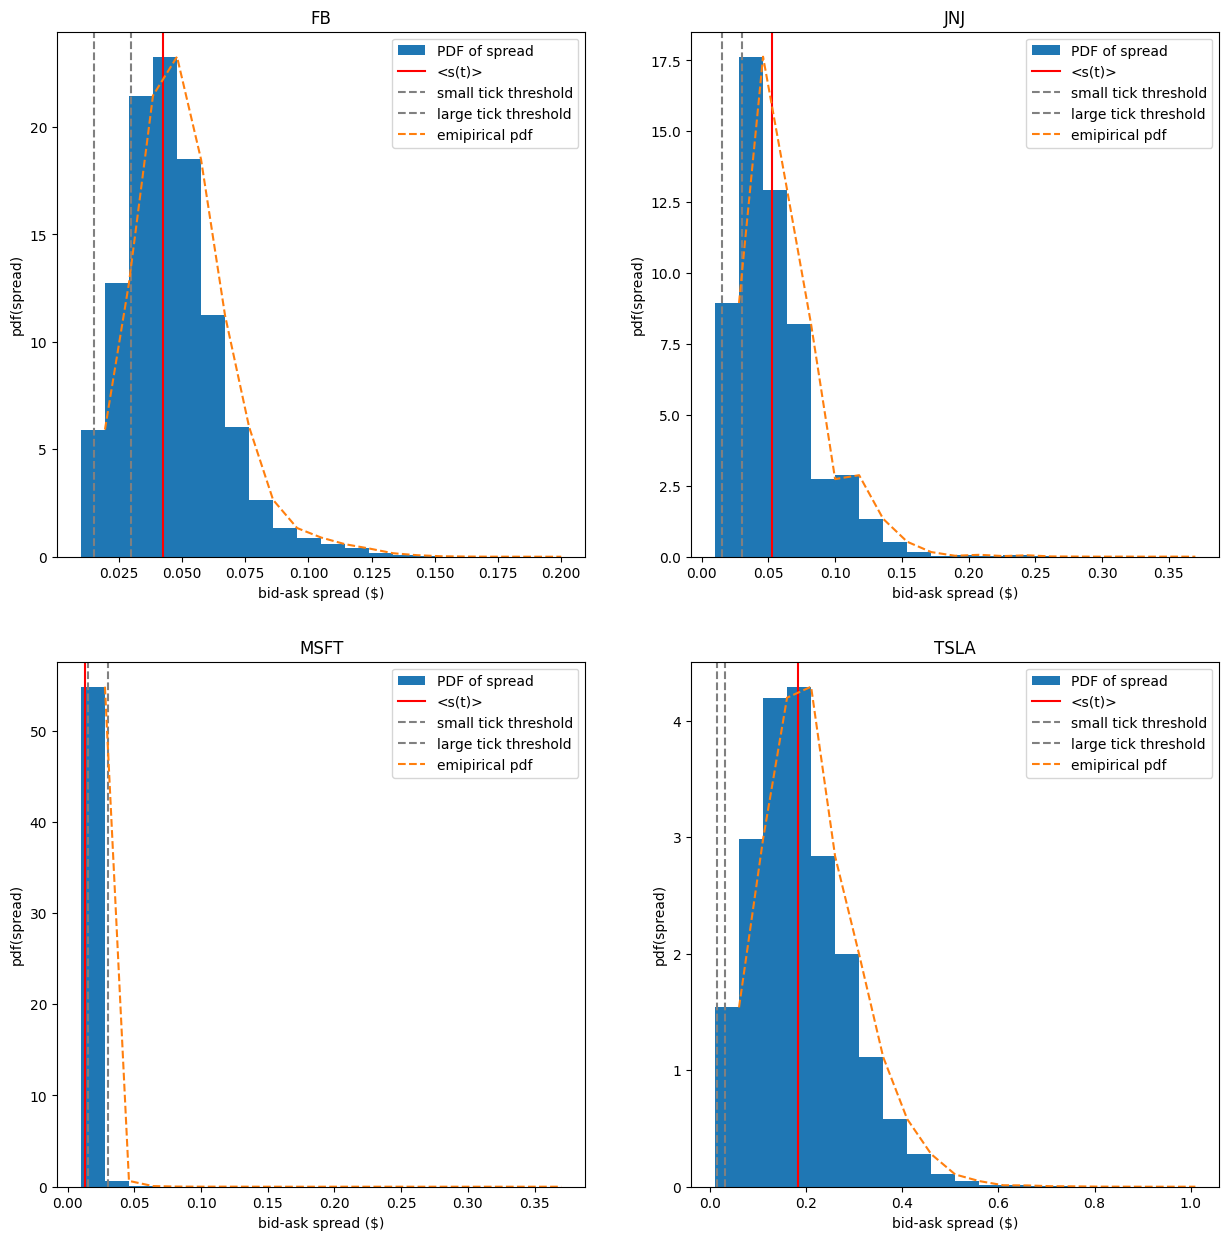

In [5]:
def plot_spread_distribution(portfolio,overplot=True):
    n_p = len(portfolio)
    fig, ax = plt.subplots(int(np.ceil(n_p/2)),int(np.ceil(n_p/2)),figsize=(15,15))
    ax = ax.flatten()
    ax_i = 0
    for stock in portfolio:
        df = portfolio[stock]
        spread = df["Spread"]
        avg_spread = df["Spread"].mean()
        tau = df["Ask_Price_Level_1"] - df["Ask_Price_Level_1"].shift(1)
        tau = tau[tau != 0].abs().min().round(10)
        threshold_small = 3*tau
        threshold_large = 1.5*tau
        emp = ax[ax_i].hist(spread,density="pdf",bins=20,label="PDF of spread")
        ax[ax_i].axvline(avg_spread,color="red",label="<s(t)>")
        ax[ax_i].axvline(threshold_small,color="Gray",linestyle="--",label="small tick threshold")
        ax[ax_i].axvline(threshold_large,color="Gray",linestyle="--",label="large tick threshold")
        if overplot:
            ax[ax_i].plot(emp[1][1:],emp[0],ls="--",label="emipirical pdf")
        ax[ax_i].set_title(f"{stock}")
        ax[ax_i].set_ylabel("pdf(spread)")
        ax[ax_i].set_xlabel("bid-ask spread ($)")

        ax[ax_i].legend()
        ax_i += 1

plot_spread_distribution(portfolio)


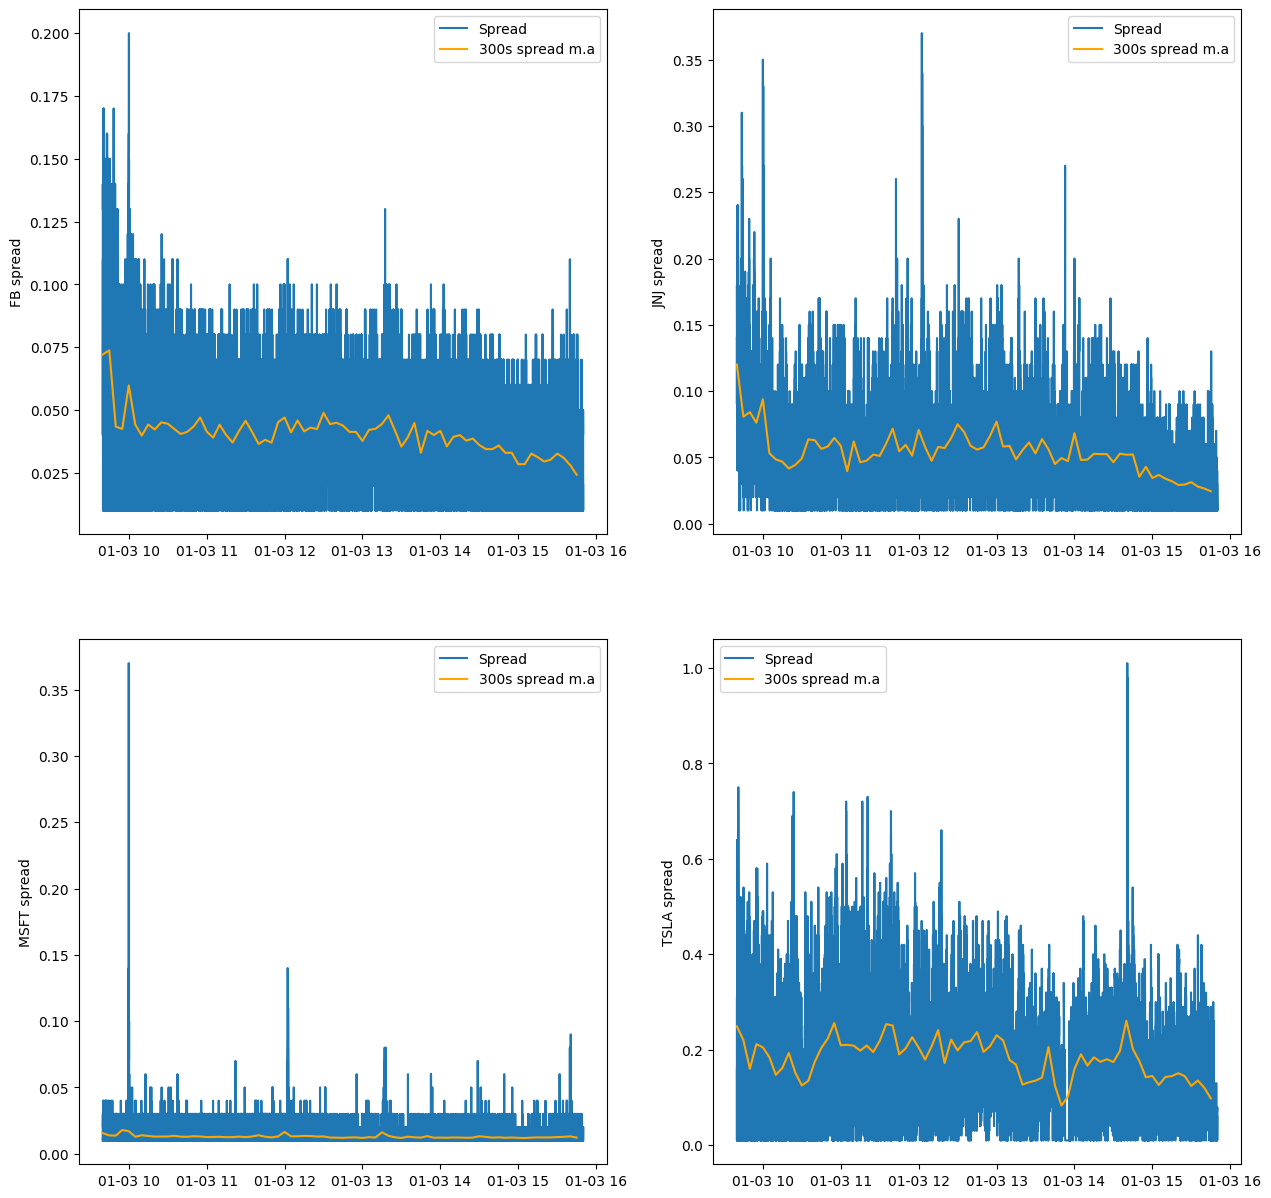

In [6]:
def plot_spread(portfolio,window=300):
    n_p = len(portfolio)
    fig, ax = plt.subplots(int(np.ceil(n_p/2)),int(np.ceil(n_p/2)),figsize=(15,15))
    ax = ax.flatten()
    ax_i = 0
    for stock in portfolio:
        df = portfolio[stock]
        spread_ma = df["Spread"].resample(f"{window}s").mean()

        ax[ax_i].plot(df["Spread"],label="Spread")
        ax[ax_i].plot(spread_ma,color="orange",label=f"{window}s spread m.a")
        ax[ax_i].legend()
        ax[ax_i].set_ylabel(f"{stock} spread")
        ax_i += 1

plot_spread(portfolio)

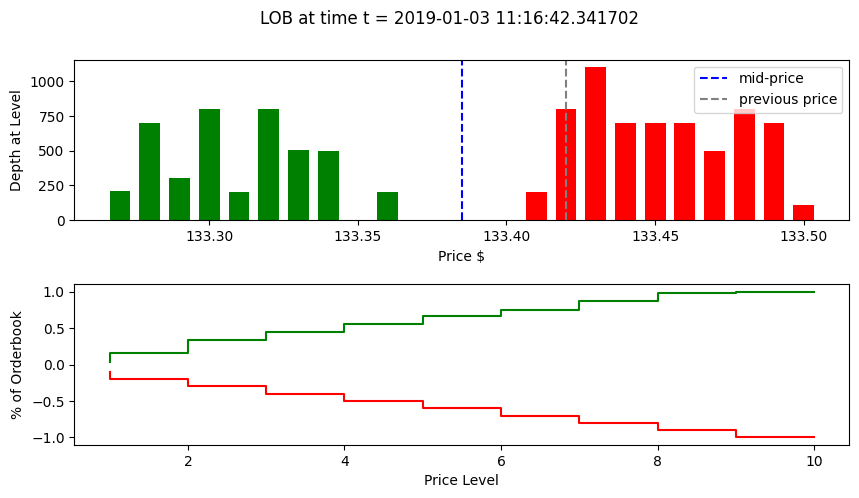

In [7]:
def plot_lob_snapshot(df):
    t = np.random.randint(0,len(df))
    fig, ax = plt.subplots(2,1,figsize=(10,5))
    plt.subplots_adjust(hspace=0.4)
    for i in range(10):
        ax[0].bar(df[f"Ask_Price_Level_{i+1}"].iloc[t],df[f"Ask_Volume_Level_{i+1}"].iloc[t],width=0.007,color="red")
        ax[0].bar(df[f"Bid_Price_Level_{i+1}"].iloc[t],df[f"Bid_Volume_Level_{i+1}"].iloc[t],width=0.007,color="green")
    ax[0].axvline(df["Mid"].iloc[t], color='blue', linestyle='--',label="mid-price")
    ax[0].axvline(df["Price"].iloc[t], color='Gray', linestyle='--',label="previous price")

    ax[1].step(range(1,11),(df.iloc[t, 7:-2:4]).cumsum()/(df.iloc[t, 7:-2:4]).sum(),color="green")
    ax[1].step(range(1,11),-1*(df.iloc[t, 8:-2:4]).cumsum()/(df.iloc[t, 8:-2:4]).sum(),color="red")

    ax[0].set_xlabel("Price $")
    ax[0].set_ylabel("Depth at Level")
    ax[1].set_xlabel("Price Level")
    ax[1].set_ylabel(r"% of Orderbook")
    ax[0].legend()
    fig.suptitle(f"LOB at time t = {df['DateTime'].iloc[t]}")

plot_lob_snapshot(portfolio["FB"])

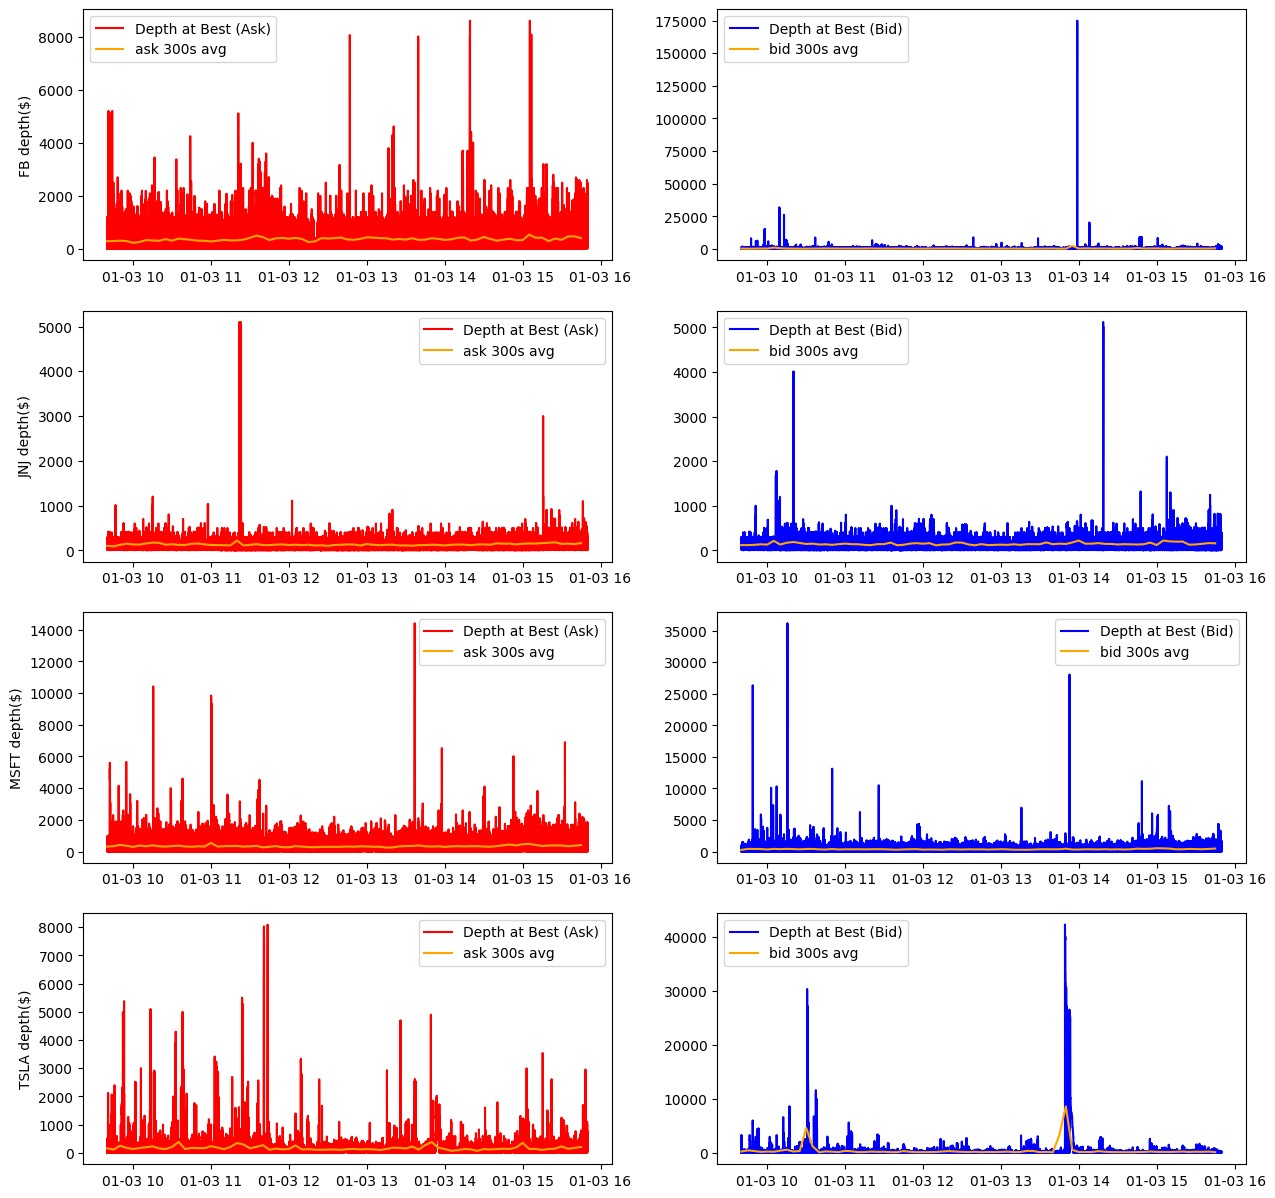

In [8]:
def plot_depth_at_best(portfolio,window=300):    
    n_p = len(portfolio)
    fig, ax = plt.subplots(int(np.ceil(n_p)),int(np.ceil(n_p/2)),figsize=(15,15))
    ax = ax.flatten()
    ax_i = 0
    for stock in portfolio:
        df = portfolio[stock]
        df["DoB_ask"] = df["Ask_Volume_Level_1"]
        df["DoB_bid"] = df["Bid_Volume_Level_1"]
        ax[ax_i].plot(df["DoB_ask"],color="red",label = "Depth at Best (Ask)")
        ax[ax_i].plot(df["DoB_ask"].resample(f"{window}s").mean(),color="orange",label=f"ask {window}s avg")
        ax[ax_i].legend()
        ax[ax_i].set_ylabel(f"{stock} depth($)")
        ax_i += 1
        ax[ax_i].plot(df["DoB_bid"],color="blue",label = "Depth at Best (Bid)")
        ax[ax_i].plot(df["DoB_bid"].resample(f"{window}s").mean(),color="orange",label=f"bid {window}s avg")
        ax[ax_i].legend()
        ax_i += 1

plot_depth_at_best(portfolio)

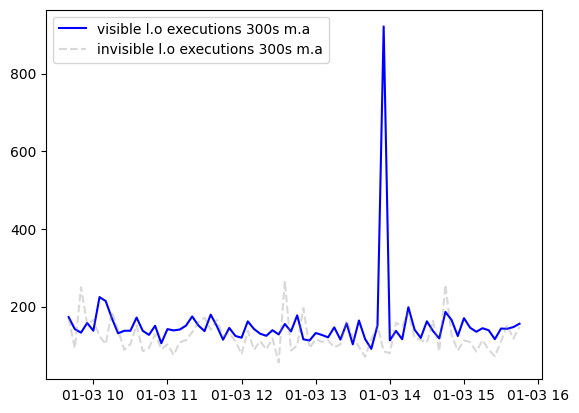

In [9]:
## Visible limit order exectuions
def plot_executions(df,window=300):
    executions_vis = df[(df["Event_Type"]==4)]
    executions_invis = df[(df["Event_Type"]==5)]
    e_vis_ma = executions_vis["Size"].resample(f"{window}s").mean()
    e_invis_ma = executions_invis["Size"].resample(f"{window}s").mean()

    plt.plot(e_vis_ma,color="blue",label=f"visible l.o executions {window}s m.a")
    plt.plot(e_invis_ma,linestyle="--",color="Gray",alpha=0.3,label=f"invisible l.o executions {window}s m.a")
    plt.legend()

plot_executions(portfolio["FB"])

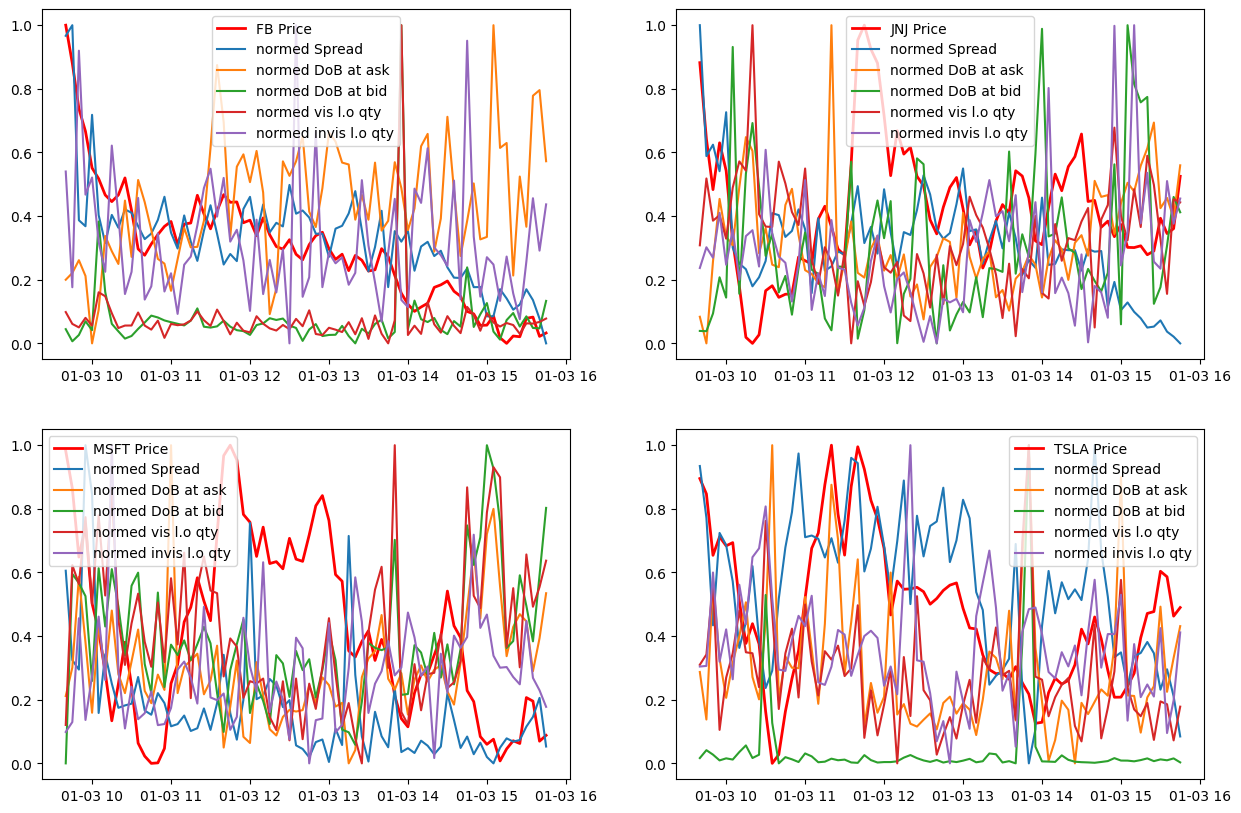

In [10]:
def plot_time_series(portfolio,window=300):
    n_p = len(portfolio)
    fig, ax = plt.subplots(int(np.ceil(n_p/2)),int(np.ceil(n_p/2)),figsize=(15,10))
    ax = ax.flatten()
    ax_i = 0
    for stock in portfolio:
        df = portfolio[stock]
        executions_vis = df[(df["Event_Type"]==4)]
        executions_invis = df[(df["Event_Type"]==5)]
        e_vis_ma = executions_vis["Size"].resample(f"{window}s").mean()
        e_invis_ma = executions_invis["Size"].resample(f"{window}s").mean()
        spread_ma = df["Spread"].resample(f"{window}s").mean()
        dob_a_ma = df["DoB_ask"].resample(f"{window}s").mean()
        dob_b_ma = df["DoB_bid"].resample(f"{window}s").mean()
        price_ma = df["Price"].resample(f"{window}s").mean()
        z_spread = (spread_ma-spread_ma.min())/(spread_ma.max()-spread_ma.min())
        z_dob_a = (dob_a_ma-dob_a_ma.min())/(dob_a_ma.max()-dob_a_ma.min())
        z_dob_b = (dob_b_ma-dob_b_ma.min())/(dob_b_ma.max()-dob_b_ma.min())
        z_e_vis = (e_vis_ma-e_vis_ma.min())/(e_vis_ma.max()-e_vis_ma.min())
        z_e_invis = (e_invis_ma-e_invis_ma.min())/(e_invis_ma.max()-e_invis_ma.min())
        z_price = (price_ma-price_ma.min())/(price_ma.max()-price_ma.min())
        ax[ax_i].plot(z_price,color="red",lw=2,label=f"{stock} Price")
        ax[ax_i].plot(z_spread,label="normed Spread")
        ax[ax_i].plot(z_dob_a,label="normed DoB at ask")
        ax[ax_i].plot(z_dob_b,label="normed DoB at bid")
        ax[ax_i].plot(z_e_vis,label="normed vis l.o qty")
        ax[ax_i].plot(z_e_invis,label="normed invis l.o qty")
        ax[ax_i].legend()
        ax_i += 1

plot_time_series(portfolio)

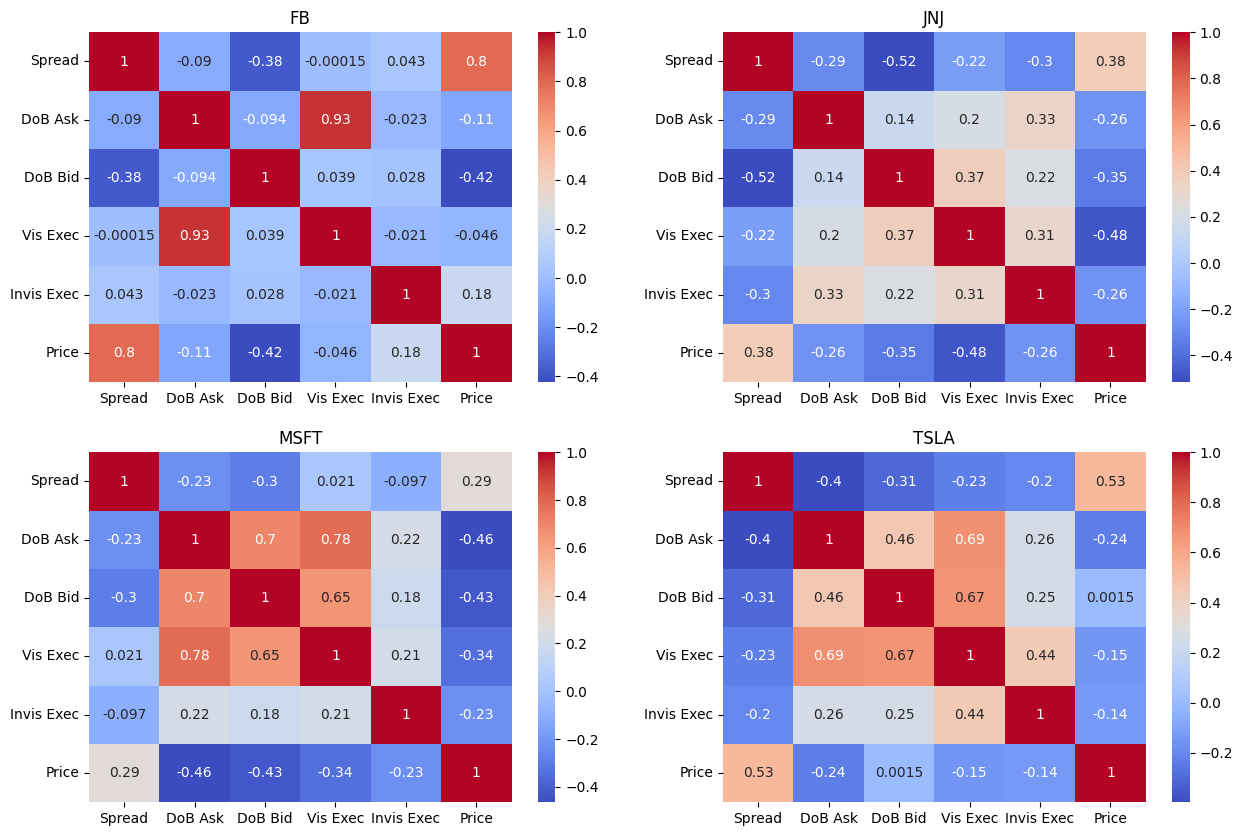

In [11]:
def correlation_matrix(portfolio,window=300):
    n_p = len(portfolio)
    fig, ax = plt.subplots(int(np.ceil(n_p/2)),int(np.ceil(n_p/2)),figsize=(15,10))
    ax = ax.flatten()
    ax_i = 0
    for stock in portfolio:
        df = portfolio[stock]
        executions_vis = df[(df["Event_Type"]==4)]
        executions_invis = df[(df["Event_Type"]==5)]
        e_vis_ma = executions_vis["Size"].resample(f"{window}s").mean()
        e_invis_ma = executions_invis["Size"].resample(f"{window}s").mean()
        spread_ma = df["Spread"].resample(f"{window}s").mean()
        dob_a_ma = df["DoB_ask"].resample(f"{window}s").mean()
        dob_b_ma = df["DoB_bid"].resample(f"{window}s").mean()
        price_ma = df["Price"].resample(f"{window}s").mean()        
        corr_matrix = np.corrcoef((spread_ma,dob_b_ma,dob_a_ma,e_vis_ma,e_invis_ma,price_ma))
        ticks = ['Spread', 'DoB Ask', 'DoB Bid', 'Vis Exec','Invis Exec','Price']
        sns.heatmap(corr_matrix, annot=True,cmap="coolwarm" ,xticklabels=ticks,yticklabels=ticks,ax=ax[ax_i])
        ax[ax_i].set_title(f"{stock}")
        ax_i += 1
correlation_matrix(portfolio)

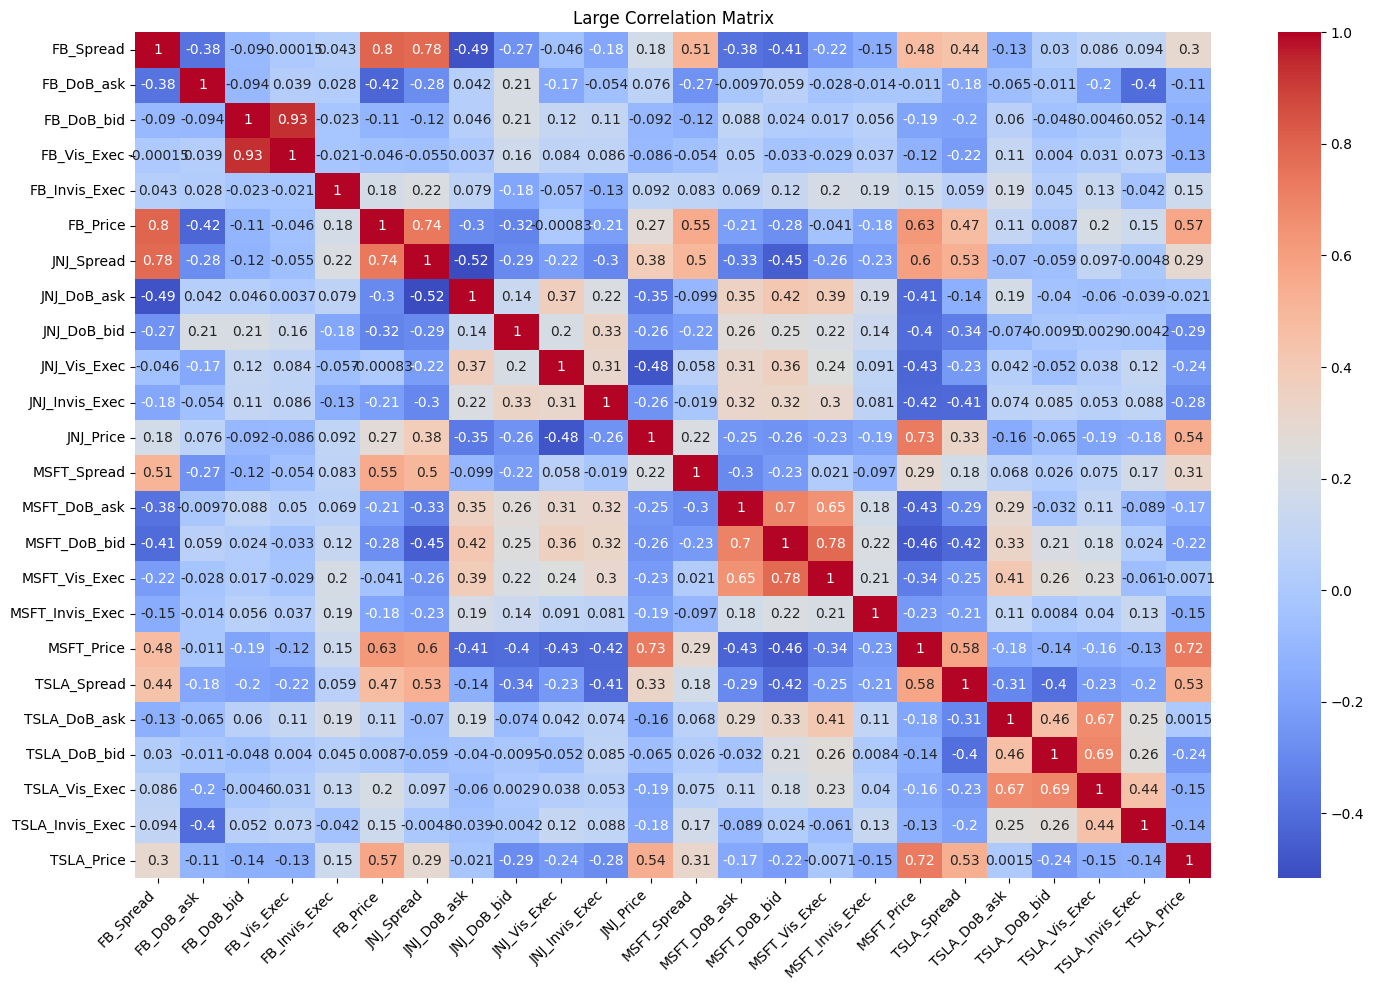

In [12]:

def large_correlation_matrix(portfolio, window=300):
    combined_data = []
    ticks = []
    
    for stock in portfolio:
        df = portfolio[stock]
        executions_vis = df[(df["Event_Type"] == 4)]
        executions_invis = df[(df["Event_Type"] == 5)]
        e_vis_ma = executions_vis["Size"].resample(f"{window}s").mean()
        e_invis_ma = executions_invis["Size"].resample(f"{window}s").mean()
        spread_ma = df["Spread"].resample(f"{window}s").mean()
        dob_a_ma = df["DoB_ask"].resample(f"{window}s").mean()
        dob_b_ma = df["DoB_bid"].resample(f"{window}s").mean()
        price_ma = df["Price"].resample(f"{window}s").mean()

        # Combine data for this stock
        stock_data = pd.DataFrame({
            f'{stock}_Spread': spread_ma,
            f'{stock}_DoB_ask': dob_a_ma,
            f'{stock}_DoB_bid': dob_b_ma,
            f'{stock}_Vis_Exec': e_vis_ma,
            f'{stock}_Invis_Exec': e_invis_ma,
            f'{stock}_Price': price_ma
        })
        combined_data.append(stock_data)
        ticks.extend(stock_data.columns)
    
    # Concatenate all stocks into a single DataFrame
    combined_data = pd.concat(combined_data, axis=1)
    
    # Calculate correlation matrix
    corr_matrix = combined_data.corr()
    
    # Plot the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", xticklabels=ticks, yticklabels=ticks)
    plt.title("Large Correlation Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

large_correlation_matrix(portfolio)

Let's look into the high correlation between spread and price for FB.